In [6]:
from mesa import Model
from mesa.time import RandomActivation
import random
from mesa import Agent
import numpy as np
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

In the code above, the DataCollector is initialized with two dictionaries: model_reporters and agent_reporters. The model_reporters dictionary tells the DataCollector to track the model-level variables (GDP, GDPpc, etc.), and the agent_reporters dictionary tells it to track the agent-level variables (Health, RPSE, etc.). The DataCollector will collect this data at every step of the model.

Once the model has run, you can retrieve the collected data using datacollector.get_model_vars_dataframe() for the model-level data and datacollector.get_agent_vars_dataframe() for the agent-level data. These methods return pandas dataframes that can be analyzed and visualized using standard data analysis and visualization tools, like pandas, matplotlib, and seaborn.

I hope this helps! Please let me know if you have further questions or if anything is unclear.

In [78]:
from mesa import Model
from mesa.time import RandomActivation
import random
from mesa import Agent
import numpy as np
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

class Country(Model):
    def __init__(self, ENERGY_MIX, GDP, GDP_GROWTH, UNEMP, RandD, TECH_PROG, EE, RPSE, INABILITY, DWELLINGS, ARREARS, POLICY, POLICY_EFFECT, NUM_AGENTS, GINI):
        super().__init__()
        self.ENERGY_MIX = ENERGY_MIX
        self.GDP = GDP
        self.GDP_GROWTH = GDP_GROWTH
        self.GDPpc = self.GDP / NUM_AGENTS
        self.UNEMP = UNEMP
        self.RandD = RandD
        self.TECH_PROG = TECH_PROG
        self.EE = EE
        self.PRICE_BEST = None  # TBD: Define how to set initial fuel prices
        self.PRICE_MEDIUM = None  # TBD: Define how to set initial fuel prices
        self.PRICE_DIRT = None  # TBD: Define how to set initial fuel prices
        self.RPSE = RPSE
        self.INABILITY = INABILITY
        self.DWELLINGS = DWELLINGS
        self.ARREARS = ARREARS
        self.NUM_AGENTS = NUM_AGENTS
        self.POLICY = POLICY
        self.POLICY_EFFECT = POLICY_EFFECT
        self.GINI = GINI
        self.schedule = RandomActivation(self)

        # Add agents
        for i in range(NUM_AGENTS):
            # Create a citizen(agent)
            a = Citizen(i, self)  # Assuming Citizen class has been created
            self.schedule.add(a)

        self.datacollector = DataCollector(
            model_reporters={"GDP": "GDP", "GDPpc": "GDPpc", "GDP_GROWTH": "GDP_GROWTH", 
                             "ENERGY_MIX": "ENERGY_MIX", "PRICE_BEST": "PRICE_BEST",
                             "PRICE_MEDIUM": "PRICE_MEDIUM", "PRICE_DIRT": "PRICE_DIRT", 
                             "RPSE":"RPSE", "UNEMP":"UNEMP", "INABILITY":"INABILITY","DWELLINGS":"DWELLINGS",
                             "ARREARS":"ARREARS","NUM_AGENTS":"NUM_AGENTS","GINI":"GINI",
                             "TECH_PROG": "TECH_PROG", "EE": "EE", "RandD": "RandD"},
            agent_reporters={"Health": "health", "RPSE": "RPSE", "INABILITY": "INABILITY", 
                             "DWELLINGS": "DWELLINGS", "ARREARS": "ARREARS", "DISP_INC":"DISP_INC"}
        )

    def step(self):
        # This is the main model step
        self.GDP *= (1 + self.GDP_GROWTH)  # GDP changes according to the GDP_GROWTH
        self.GDP_GROWTH = random.uniform(-0.01, -0.05)  # GDP growth is a random number between -1% and 5%
        self.GDPpc = self.GDP / self.schedule.get_agent_count()  # Update GDP per capita

        # Update TECH_PROG and EE based on RandD
        self.TECH_PROG += self.RandD * 0.01  # Assuming a linear relation with a factor of 0.01
        self.EE += self.TECH_PROG * 0.01  # Assuming a linear relation with a factor of 0.01

        # Update fuel prices - assumed to be random within a given range
        # User can change trend (increasing, decreasing, flat) - logic for this should be added
        self.PRICE_BEST = random.uniform(1, 10)  # These ranges are placeholders and should be set appropriately
        self.PRICE_MEDIUM = random.uniform(1, 10)  # These ranges are placeholders and should be set appropriately
        self.PRICE_DIRT = random.uniform(1, 10)  # These ranges are placeholders and should be set appropriately

        # Run all the citizen's steps
        self.schedule.step()

        # Collect data
        self.datacollector.collect(self)



class Citizen(Agent):
    def __init__(self, unique_id, model, alpha=0.5, beta=0.5, minimum_food_exp=500):
        super().__init__(unique_id, model)
        self.alpha = alpha
        self.beta = beta
        self.minimum_food_exp = minimum_food_exp

        # Initialize boolean flags
        self.RPSE = self.initialize_flag(self.model.RPSE)
        self.ARREARS = self.initialize_flag(self.model.ARREARS) if self.RPSE else False
        self.DWELLINGS = self.initialize_flag(self.model.DWELLINGS) if self.RPSE else False
        self.INABILITY = self.initialize_flag(self.model.INABILITY) if self.RPSE else False

        def expenditure_objective(self, x):
            food_exp, energy_exp = x
            return -(self.alpha * np.log(food_exp) + self.beta * np.log(energy_exp))

        def expenditure_constraints(self, x):
            food_exp, energy_exp = x
            return [self.DISP_INC - food_exp - energy_exp, food_exp - self.minimum_food_exp]

        # Initialize disposable income based on GINI index
        self.DISP_INC = self.initialize_disp_income()

        # Initialize fuel type
        self.fuel_type = random.choice(['BEST', 'MEDIUM', 'DIRT'])

        # Initialize health index
        self.health = random.uniform(65, 100)

    def initialize_disp_income(self):
        # This is a simple approximation of income distribution based on GINI index.
        income_categories = [1000, 2000, 3000, 4000, 5000, 6000, 7000]  # Placeholder for income categories
        probabilities = [self.model.GINI / sum(range(1, 8)) * i for i in range(1, 8)]
        
        # Normalize the probabilities so they sum to 1
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]

        income = np.random.choice(income_categories, p=probabilities)

        # Modify income based on RPSE status
        if self.RPSE:
            income *= 0.6  # Reduce income to 60% if RPSE is True

        return income



    def initialize_flag(self, percentage):
        return random.random() < percentage / 100

    def step(self):
        # Update citizen's state based on model's state
        if self.RPSE or self.INABILITY or self.DWELLINGS:
            self.health -= random.uniform(0, 5)  # Randomly decrease health by 0-5 points
        else:
            self.health += random.uniform(0, 5)  # Randomly increase health by 0-5 points

        # Determine optimal food and energy expenditures
        result = minimize(self.expenditure_objective, [self.minimum_food_exp, self.DISP_INC - self.minimum_food_exp], 
        constraints={'type': 'ineq', 'fun': self.expenditure_constraints})
        food_exp, energy_exp = result.x

        self.health = max(0, self.health)  # Health should not be negative
        self.health = min(100, self.health)  # Health should not exceed 100
        

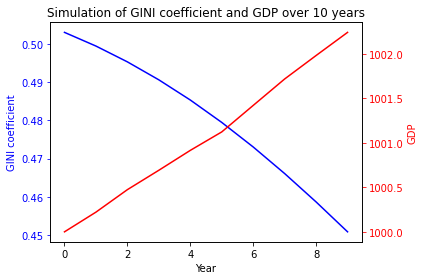

In [40]:
import random
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

class IncomeAgent(Agent):
    def __init__(self, unique_id, model, GINI):
        super().__init__(unique_id, model)
        self.disposable_income = random.uniform(0, 1)
        self.GINI = GINI

    def step(self):
        pass

class GiniModel(Model):
    def __init__(self, GINI, Z, GDP, POPULATION, GDP_GROWTH):
        self.GINI = GINI
        self.Z = Z
        self.GDP = GDP
        self.POPULATION = POPULATION
        self.GDP_GROWTH = GDP_GROWTH
        self.GDPpc = self.GDP / self.POPULATION
        self.schedule = SimultaneousActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Gini": calculate_gini, "GDP": lambda m: m.GDP},
            agent_reporters={"Income": lambda a: a.disposable_income}
        )

        # Create agents
        for i in range(self.POPULATION):
            a = IncomeAgent(i, self, self.GINI)
            self.schedule.add(a)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        lowest_agents = sorted(self.schedule.agents, key=lambda a: a.disposable_income)[:200]
        for agent in lowest_agents:
            agent.disposable_income += self.Z * agent.disposable_income

        self.GDP += random.uniform(*self.GDP_GROWTH)
        self.GDPpc = self.GDP / self.POPULATION

def calculate_gini(model):
    agents = [agent.disposable_income for agent in model.schedule.agents]
    n = len(agents)
    total_income = sum(agents)
    agents = sorted(agents)
    cumulative_income = [sum(agents[:i+1]) / total_income for i in range(n)]
    b = sum([(i+1) * cumulative_income[i] for i in range(n)])
    gini = (n + 1 - 2 * (b / n)) / n

    return gini

# Set initial parameters
GINI = 0.4
Z = 0.2
YEARS = 10
GDP = 1000
POPULATION = 1000
GDP_GROWTH = (0.2, 0.3)  # Random growth range

# Create and run the model
model = GiniModel(GINI, Z, GDP, POPULATION, GDP_GROWTH)
for _ in range(YEARS):
    model.step()

# Get and plot the GINI values and GDP over time
data = model.datacollector.get_model_vars_dataframe()
ginis = data["Gini"].tolist()
gdp_over_time = data["GDP"].tolist()

fig, ax1 = plt.subplots()
ax1.plot(range(YEARS), ginis, color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('GINI coefficient', color='blue')
ax1.tick_params('y', colors='blue')
ax1.set_title('Simulation of GINI coefficient and GDP over 10 years')

ax2 = ax1.twinx()
ax2.plot(range(YEARS), gdp_over_time, color='red')
ax2.set_ylabel('GDP', color='red')
ax2.tick_params('y', colors='red')

fig.tight_layout()
plt.show()


IntSlider(value=0, description='Year', max=9)

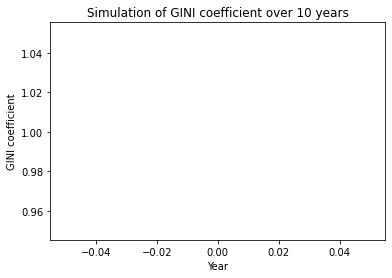

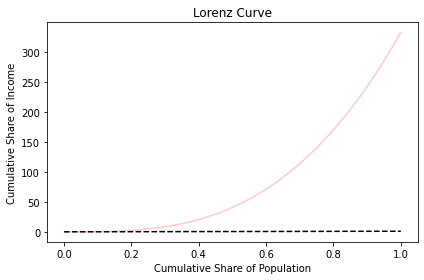

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [50]:
import random
import matplotlib.pyplot as plt
import numpy as np
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import ipywidgets as widgets
from IPython.display import display

class IncomeAgent(Agent):
    def __init__(self, unique_id, model, GINI):
        super().__init__(unique_id, model)
        self.disposable_income = random.uniform(0, 1)
        self.GINI = GINI

    def step(self):
        pass

class GiniModel(Model):
    def __init__(self, GINI, Z, GDP, POPULATION, GDP_GROWTH):
        self.GINI = GINI
        self.Z = Z
        self.GDP = GDP
        self.POPULATION = POPULATION
        self.GDP_GROWTH = GDP_GROWTH
        self.GDPpc = self.GDP / self.POPULATION
        self.schedule = SimultaneousActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Gini": calculate_gini, "cumulative_share_income": calculate_cumulative_share_income},
            agent_reporters={"Income": lambda a: a.disposable_income}
        )

        # Create agents
        for i in range(self.POPULATION):
            a = IncomeAgent(i, self, self.GINI)
            self.schedule.add(a)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        lowest_agents = sorted(self.schedule.agents, key=lambda a: a.disposable_income)[:200]
        for agent in lowest_agents:
            agent.disposable_income += self.Z * agent.disposable_income

        self.GDP += random.uniform(*self.GDP_GROWTH)
        self.GDPpc = self.GDP / self.POPULATION

def calculate_gini(model):
    agents = [agent.disposable_income for agent in model.schedule.agents]
    n = len(agents)
    total_income = sum(agents)
    agents = sorted(agents)
    cumulative_income = [sum(agents[:i+1]) for i in range(n)]
    cumulative_share_income = [cumulative_income[i] / total_income for i in range(n)]
    cumulative_share_population = [(i + 1) / n for i in range(n)]
    gini = (n + 1 - 2 * sum(cumulative_share_income) / n) / n

    return gini

def calculate_cumulative_share_income(model):
    agents = [agent.disposable_income for agent in model.schedule.agents]
    n = len(agents)
    total_income = sum(agents)
    agents = sorted(agents)
    cumulative_income = [sum(agents[:i+1]) / total_income for i in range(n)]
    cumulative_share_population = [(i + 1) / n for i in range(n)]

    return cumulative_income

# Set initial parameters
GINI = 0.4
Z = 0.2
YEARS = 10
GDP = 1000
POPULATION = 1000
GDP_GROWTH = (0.9, 1.1)  # Random growth range

# Create the model
model = GiniModel(GINI, Z, GDP, POPULATION, GDP_GROWTH)

# Create the figure and axes for GINI plot
fig_gini, ax_gini = plt.subplots()
ax_gini.set_xlabel('Year')
ax_gini.set_ylabel('GINI coefficient')
ax_gini.set_title('Simulation of GINI coefficient over 10 years')

# Create the figure and axes for Lorenz curve plot
fig_lorenz, ax_lorenz = plt.subplots()
ax_lorenz.set_xlabel('Cumulative Share of Population')
ax_lorenz.set_ylabel('Cumulative Share of Income')
ax_lorenz.set_title('Lorenz Curve')

# Create the data containers
ginis = []
lorenz_curves = []

# Create the slider
slider = widgets.IntSlider(min=0, max=YEARS-1, step=1, value=0, description='Year')

def update_plots(year):
    ax_gini.clear()
    ax_lorenz.clear()

    # Plot GINI values
    ax_gini.plot(range(year+1), ginis[:year+1], color='blue')
    ax_gini.set_xlabel('Year')
    ax_gini.set_ylabel('GINI coefficient')
    ax_gini.set_title('Simulation of GINI coefficient over 10 years')

    # Plot Lorenz curve
    for i in range(year + 1):
        lorenz_curve = lorenz_curves[i]
        x = np.arange(len(lorenz_curve) + 1) / len(lorenz_curve)
        y = np.insert(np.cumsum(np.sort(lorenz_curve)), 0, 0)
        ax_lorenz.plot(x, y, color='red', alpha=0.2)
    ax_lorenz.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax_lorenz.set_xlabel('Cumulative Share of Population')
    ax_lorenz.set_ylabel('Cumulative Share of Income')
    ax_lorenz.set_title('Lorenz Curve')

    plt.tight_layout()
    plt.show()

# Update the plots based on the slider value
def update_plots_slider(change):
    year = change['new']
    update_plots(year)

# Register the update function with the slider
slider.observe(update_plots_slider, names='value')

# Run the model and collect data
for _ in range(YEARS):
    model.step()
    data = model.datacollector.get_model_vars_dataframe()
    ginis.append(data["Gini"].iloc[-1])
    lorenz_curves.append(data["cumulative_share_income"].iloc[-1])

# Display the slider and initial plots
display(slider)
update_plots(0)


In [53]:
import random
import matplotlib.pyplot as plt
import numpy as np

class Country(Model):
    def __init__(self, GINI, Z, GDP, POPULATION, GDP_GROWTH, YEARS):
        super().__init__()
        self.GINI = GINI
        self.Z = Z
        self.GDP = GDP
        self.POPULATION = POPULATION
        self.GDP_GROWTH = GDP_GROWTH
        self.YEARS = YEARS
        self.GDPpc = self.GDP / self.POPULATION
        self.disposable_income = []
        self.cumulative_income_share = []

    def calculate_disposable_income(self):
        quintiles = np.linspace(0, 1, 6)  # Divide population into quintiles
        income_distribution = np.random.normal(loc=0, scale=1, size=self.POPULATION)
        sorted_income = np.sort(income_distribution)
        thresholds = np.percentile(sorted_income, quintiles * 100)
        income_quintiles = np.digitize(income_distribution, thresholds)
        disposable_income = []

        for quintile in income_quintiles:
            disp_inc = self.GINI * (quintile / 5) * self.GDPpc
            disposable_income.append(disp_inc)

        self.disposable_income = disposable_income

    def calculate_cumulative_income_share(self):
        cumulative_income = np.cumsum(sorted(self.disposable_income))
        total_income = np.sum(self.disposable_income)
        cumulative_income_share = cumulative_income / total_income
        self.cumulative_income_share = cumulative_income_share

    def step(self):
        self.calculate_disposable_income()
        self.GDP += random.uniform(*self.GDP_GROWTH)
        self.GDPpc = self.GDP / self.POPULATION
        self.calculate_cumulative_income_share()

    def run_model(self):
        lorenz_curve_data = []

        for _ in range(self.YEARS):
            self.step()
            lorenz_curve_data.append(self.cumulative_income_share)

        lorenz_curve_data = np.array(lorenz_curve_data)
        lorenz_curve_data = np.insert(lorenz_curve_data, 0, [0] * len(lorenz_curve_data), axis=1)  # Add (0, 0) point


        x_vals = np.linspace(0, 1, len(lorenz_curve_data[0]))

        plt.plot(x_vals, lorenz_curve_data[-1], label=f"Year {self.YEARS}")
        plt.plot(x_vals, x_vals, linestyle="--", color="black", label="Equality Line")
        plt.xlabel("Cumulative Share of Population")
        plt.ylabel("Cumulative Share of Income")
        plt.title("Lorenz Curve")
        plt.legend()
        plt.show()


In [64]:
import random
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display


class Country(Model):
    def __init__(self, GINI, Z, GDP, POPULATION, GDP_GROWTH, YEARS):
        super().__init__()
        self.GINI = GINI
        self.Z = Z
        self.GDP = GDP
        self.POPULATION = POPULATION
        self.GDP_GROWTH = GDP_GROWTH
        self.YEARS = YEARS
        self.GDPpc = self.GDP / self.POPULATION
        self.disposable_income = []
        self.cumulative_income_share = []
        self.income_quintiles = []

    def calculate_disposable_income(self):
        quintiles = np.linspace(0, 1, 6)  # Divide population into quintiles
        income_distribution = np.random.normal(loc=0, scale=1, size=self.POPULATION)
        sorted_income = np.sort(income_distribution)
        cumulative_share = np.cumsum(sorted_income) / np.sum(sorted_income)
        target_cumulative_share = np.linspace(0, 1, len(quintiles))
        interpolated_income = np.interp(target_cumulative_share, cumulative_share, sorted_income)

        self.disposable_income = interpolated_income
        self.income_quintiles = np.digitize(income_distribution, np.percentile(sorted_income, quintiles * 100))

    def calculate_cumulative_income_share(self):
        cumulative_income = np.cumsum(sorted(self.disposable_income))
        total_income = np.sum(self.disposable_income)
        cumulative_income_share = cumulative_income / total_income
        self.cumulative_income_share = cumulative_income_share

    def step(self):
        self.calculate_disposable_income()
        self.GDP += random.uniform(*self.GDP_GROWTH)
        self.GDPpc = self.GDP / self.POPULATION
        self.calculate_cumulative_income_share()

    def run_model(self):
        lorenz_curve_data = []
        income_quintiles_over_time = []

        for _ in range(self.YEARS):
            self.step()
            lorenz_curve_data.append(self.cumulative_income_share)
            income_quintiles_over_time.append(self.income_quintiles)

        lorenz_curve_data = np.array(lorenz_curve_data)
        lorenz_curve_data = np.insert(lorenz_curve_data, 0, [0] * len(lorenz_curve_data), axis=1)  # Add (0, 0) point

        # Plot Lorenz Curve
        x_vals = np.linspace(0, 1, len(lorenz_curve_data[0]))
        plt.plot(x_vals, lorenz_curve_data[-1], label=f"Year {self.YEARS}")
        plt.plot(x_vals, x_vals, linestyle="--", color="black", label="Equality Line")
        plt.xlabel("Cumulative Share of Population")
        plt.ylabel("Cumulative Share of Income")
        plt.title("Lorenz Curve")
        plt.legend()
        plt.show()

        # Plot Income Quintiles Over Time
        fig, ax = plt.subplots()
        ax.set_xlabel("Year")
        ax.set_ylabel("Count")
        ax.set_title("Income Quintiles Over Time")

        income_quintiles_over_time = np.array(income_quintiles_over_time)

        for i in range(5):
            ax.plot(np.arange(self.YEARS), np.sum(income_quintiles_over_time == i + 1, axis=1), label=f"Quintile {i+1}")

        ax.legend()
        plt.show()

        # Create slider to visualize changes over time
        slider = widgets.IntSlider(min=0, max=self.YEARS - 1, step=1, value=0)
        widgets.interact(self.plot_quintiles_histogram, step=slider)

    def plot_quintiles_histogram(self, step):
        fig, ax = plt.subplots()
        ax.hist(self.income_quintiles[step], bins=5, range=(1, 6), align='mid')
        ax.set_xlabel("Quintile")
        ax.set_ylabel("Count")
        ax.set_title(f"Income Quintiles - Year {step+1}")
        plt.show()


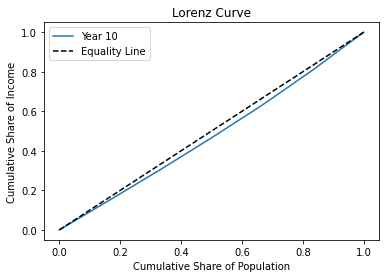

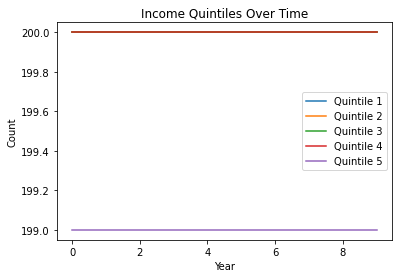

interactive(children=(IntSlider(value=0, description='step', max=9), Output()), _dom_classes=('widget-interact…

In [67]:
country = Country(GINI=0.1, Z=0.2, GDP=5000, POPULATION=1000, GDP_GROWTH=(100, 500), YEARS=10)
country.run_model()


In [76]:
import random
import matplotlib.pyplot as plt
import numpy as np
from mesa.time import BaseScheduler

class Country(Model):
    def __init__(self, initial_population, minimum_sugar_endowment, maximum_sugar_endowment, vision_range, metabolism_range, max_age_range, sugar_map_file, years):
        super().__init__()
        self.initial_population = initial_population
        self.minimum_sugar_endowment = minimum_sugar_endowment
        self.maximum_sugar_endowment = maximum_sugar_endowment
        self.vision_range = vision_range
        self.metabolism_range = metabolism_range
        self.max_age_range = max_age_range
        self.sugar_map_file = sugar_map_file
        self.years = years
        self.gini_index_reserve = []
        self.lorenz_points = []
        self.schedule = None 

    def setup(self):
        if self.maximum_sugar_endowment <= self.minimum_sugar_endowment:
            raise ValueError("Oops: the maximum-sugar-endowment must be larger than the minimum-sugar-endowment")
        
        self.clear_turtles()
        self.clear_patches()
        self.create_turtles(self.initial_population)
        self.setup_patches()
        self.update_lorenz_and_gini()
        self.reset_ticks()
    
    def clear_turtles(self):
        self.schedule = BaseScheduler(self)
        self.schedule.clear()

    def clear_patches(self):
        self.grid.clear()

    def turtle_setup(self, turtle):
        turtle.color = 'red'
        turtle.shape = 'circle'
        turtle.move_to(self.one_of(self.patches().is_empty()))
        turtle.sugar = random.randint(self.minimum_sugar_endowment, self.maximum_sugar_endowment)
        turtle.metabolism = random.randint(1, 4)
        turtle.max_age = random.randint(60, 100)
        turtle.age = 0
        turtle.vision = random.randint(1, 6)
        turtle.vision_points = []
        for n in range(1, turtle.vision + 1):
            turtle.vision_points.append((0, n))
            turtle.vision_points.append((n, 0))
            turtle.vision_points.append((0, -n))
            turtle.vision_points.append((-n, 0))
        self.visualization(turtle)

    def setup_patches(self):
        with open(self.sugar_map_file, 'r') as file:
            for patch in self.patches():
                patch.max_psugar = int(file.readline())
                patch.psugar = patch.max_psugar
                self.patch_recolor(patch)

    def go(self):
        if not self.turtles:
            return
        for patch in self.patches():
            self.patch_growback(patch)
            self.patch_recolor(patch)
        for turtle in self.turtles:
            turtle.turtle_move()
            turtle.turtle_eat()
            turtle.age += 1
            if turtle.sugar <= 0 or turtle.age > turtle.max_age:
                self.hatch(1, self.turtle_setup)
                turtle.die()
            self.visualization(turtle)
        self.update_lorenz_and_gini()
        self.tick()

    def turtle_move(self, turtle):
        move_candidates = [patch for patch in self.patches_here() + self.patches_at_points(turtle.vision_points) if patch.is_empty()]
        possible_winners = [patch for patch in move_candidates if patch.psugar == max([p.psugar for p in move_candidates])]
        if possible_winners:
            turtle.move_to(self.min_one_of(possible_winners, lambda p: turtle.distance(p)))

    def turtle_eat(self, turtle):
        turtle.sugar = turtle.sugar - turtle.metabolism + turtle.patch_here().psugar
        turtle.patch_here().psugar = 0

    def patch_recolor(self, patch):
        patch.pcolor = plt.cm.YlOrRd(patch.psugar / 5)

    def patch_growback(self, patch):
        patch.psugar = min(patch.max_psugar, patch.psugar + 1)

    def update_lorenz_and_gini(self):
        num_people = len(self.turtles)
        sorted_wealths = sorted([turtle.sugar for turtle in self.turtles])
        total_wealth = sum(sorted_wealths)
        wealth_sum_so_far = 0
        self.gini_index_reserve = []
        self.lorenz_points = []
        for index in range(num_people):
            wealth_sum_so_far += sorted_wealths[index]
            self.lorenz_points.append((wealth_sum_so_far / total_wealth) * 100)
            self.gini_index_reserve.append((index / num_people) - (wealth_sum_so_far / total_wealth))

    def report_lorenz_curve(self):
        plt.plot(range(self.years), self.lorenz_points)
        plt.xlabel("Year")
        plt.ylabel("Cumulative Share of Wealth (%)")
        plt.title("Lorenz Curve")
        plt.show()

    def report_wealth_distribution(self):
        wealth_distribution = [turtle.sugar for turtle in self.turtles]
        plt.hist(wealth_distribution, bins=10, alpha=0.7)
        plt.xlabel("Wealth")
        plt.ylabel("Count")
        plt.title("Wealth Distribution")
        plt.show()

    def report_gini_index(self):
        plt.plot(range(self.years), self.gini_index_reserve)
        plt.xlabel("Year")
        plt.ylabel("Gini Index Reserve")
        plt.title("Gini Index")
        plt.show()



In [ ]:
class Country(Model):
    def __init__(self, GINI, Z, GDP, POPULATION, GDP_GROWTH, YEARS):
        super().__init__()
        self.GINI = GINI
        self.Z = Z
        self.GDP = GDP
        self.POPULATION = POPULATION
        self.GDP_GROWTH = GDP_GROWTH
        self.YEARS = YEARS
        self.GDPpc = self.GDP / self.POPULATION
        self.disposable_income = []
        self.cumulative_income_share = []
        self.income_quintiles = []
        self.lorenz_curve_data = []
        self.gini_index_data = []

    def calculate_disposable_income(self):
        # Calculate disposable income based on GINI coefficient
        # ...
        pass 

    def calculate_cumulative_income_share(self):
        # Calculate cumulative income share
        # ...
        pass

    def step(self):
        self.calculate_disposable_income()
        self.GDP += random.uniform(*self.GDP_GROWTH)
        self.GDPpc = self.GDP / self.POPULATION
        self.calculate_cumulative_income_share()
        self.lorenz_curve_data.append(self.cumulative_income_share)
        self.gini_index_data.append(sum(self.gini_index_reserve) / self.POPULATION)

    def run_model(self):
        for _ in range(self.YEARS):
            self.step()

        # Plot Lorenz curve
        # ...

        # Plot wealth distribution
        # ...

        # Plot Gini index
        # ...


In [77]:
country = Country(
    initial_population=100,
    minimum_sugar_endowment=5,
    maximum_sugar_endowment=10,
    vision_range=(1, 6),
    metabolism_range=(1, 4),
    max_age_range=(60, 100),
    sugar_map_file="sugar-map.txt",
    years=10
)

country.setup()
for _ in range(country.years):
    country.go()

country.report_lorenz_curve()
country.report_wealth_distribution()
country.report_gini_index()


AttributeError: 'BaseScheduler' object has no attribute 'clear'

In [63]:
country = Country(GINI=0.4, Z=0.2, GDP=5000, POPULATION=1000, GDP_GROWTH=(100, 500), YEARS=10)
country.run_model()


ValueError: fp and xp are not of the same length.

In [24]:
# vars(Citizen)

In [79]:
agent_data = model.datacollector.get_agent_vars_dataframe()

shares_data = pd.DataFrame()
shares_data['RPSE'] = agent_data['RPSE'].groupby('Step').apply(lambda x: x.sum() / len(x))
shares_data['INABILITY'] = agent_data['INABILITY'].groupby('Step').apply(lambda x: x.sum() / len(x))
shares_data['DWELLINGS'] = agent_data['DWELLINGS'].groupby('Step').apply(lambda x: x.sum() / len(x))
shares_data['ARREARS'] = agent_data['ARREARS'].groupby('Step').apply(lambda x: x.sum() / len(x))


KeyError: 'RPSE'

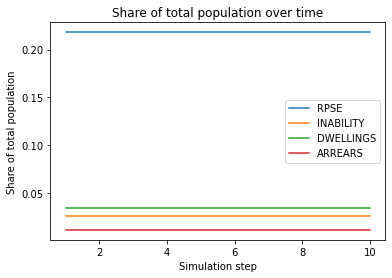

In [18]:
shares_data.plot()
plt.xlabel('Simulation step')
plt.ylabel('Share of total population')
plt.title('Share of total population over time')
plt.legend(['RPSE', 'INABILITY', 'DWELLINGS', 'ARREARS'])
plt.show()


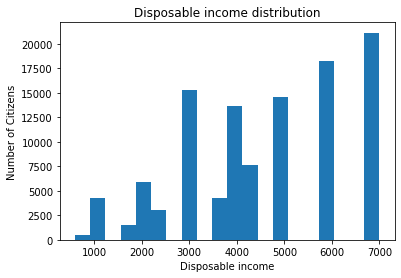

In [19]:
import matplotlib.pyplot as plt

# Run your model for a certain number of steps
for i in range(100):  # 100 steps as an example
    model.step()

# Retrieve the collected data
agent_data = model.datacollector.get_agent_vars_dataframe()

# Plot the disposable income distribution
plt.hist(agent_data['DISP_INC'], bins=20)
plt.xlabel('Disposable income')
plt.ylabel('Number of Citizens')
plt.title('Disposable income distribution')
plt.show()


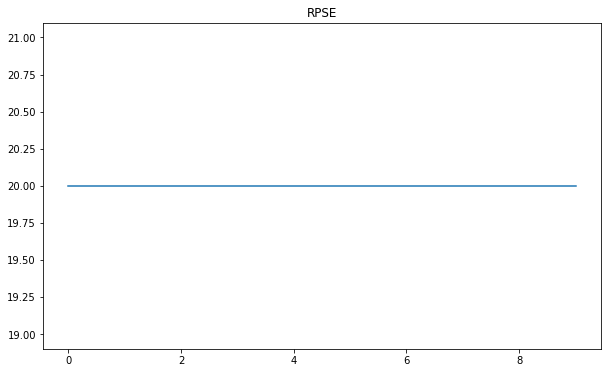

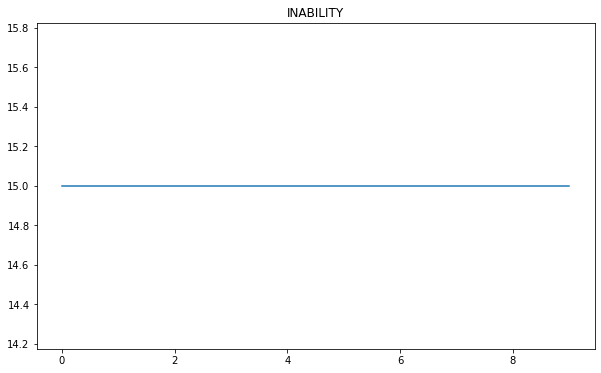

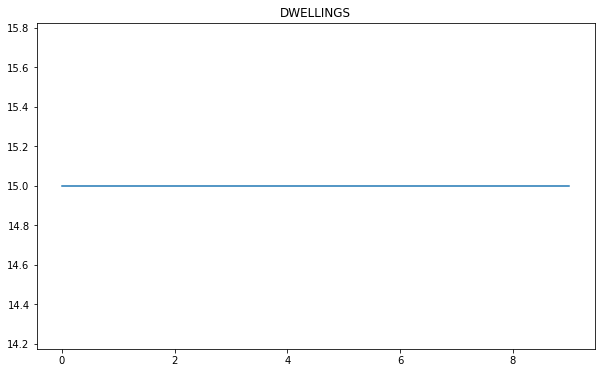

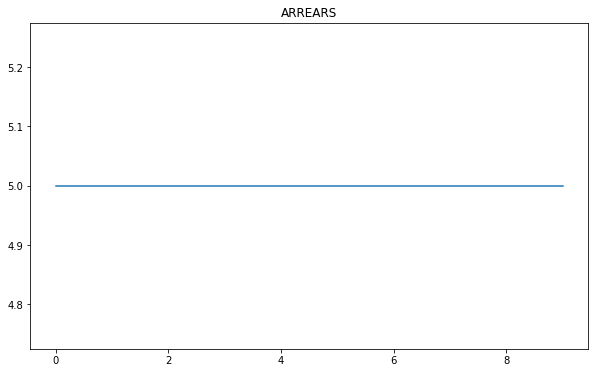

In [21]:
CITIZENS_VARS = ['RPSE', 'INABILITY', 'DWELLINGS', 'ARREARS']


for i in CITIZENS_VARS:

    plt.figure(figsize=(10, 6))
    plt.plot(model_data[i])
    plt.title(str(i))
    plt.show()


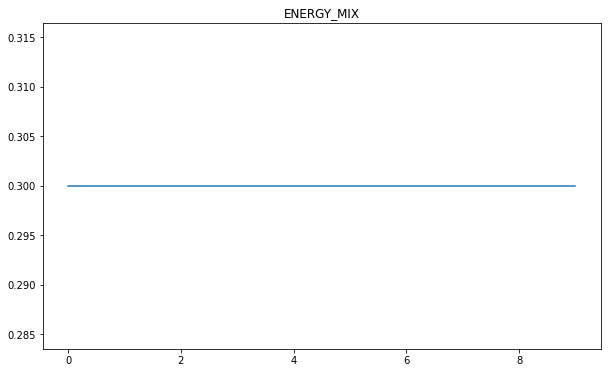

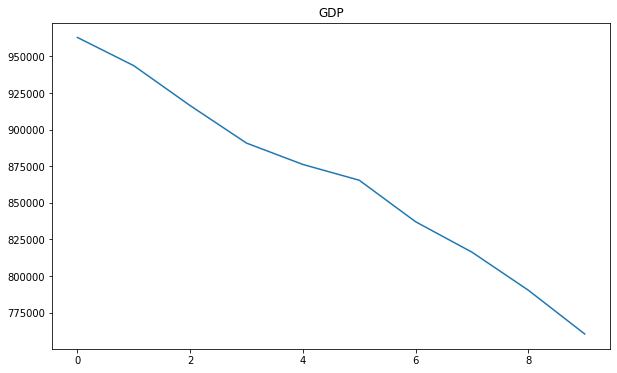

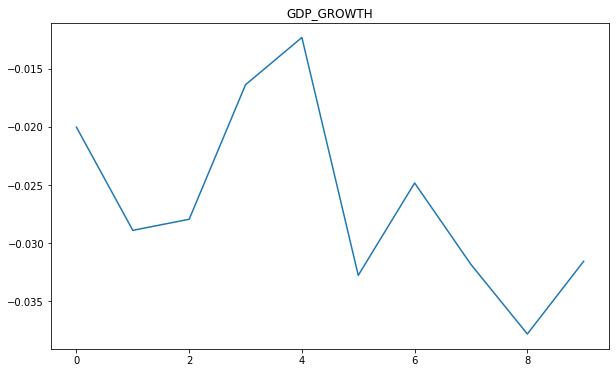

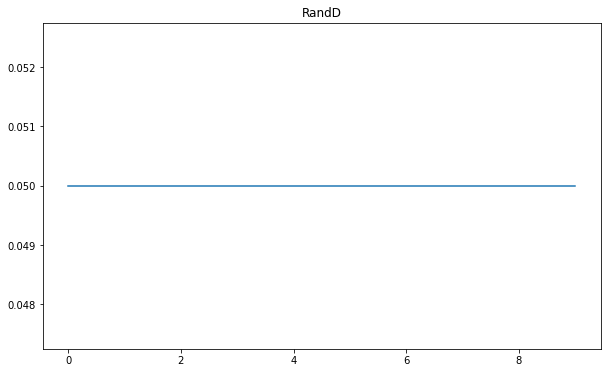

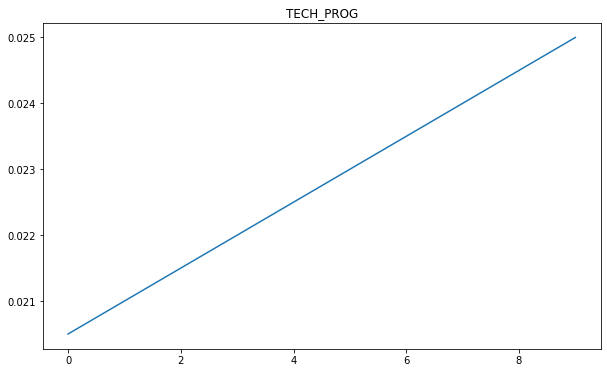

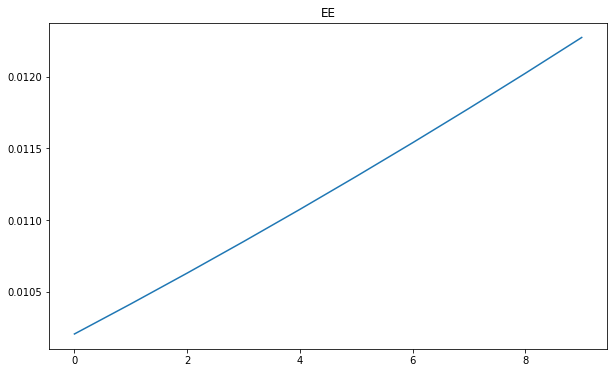

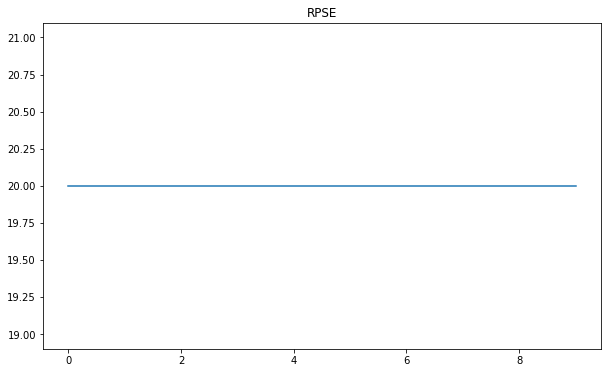

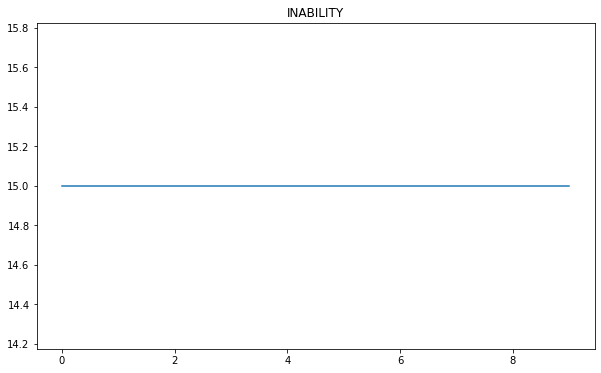

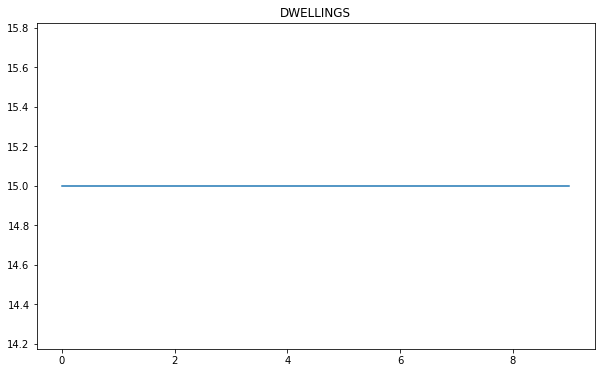

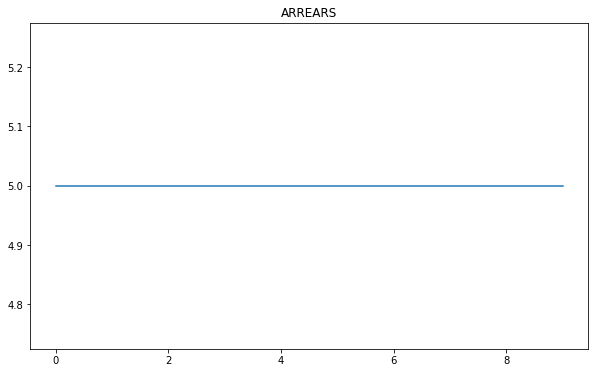

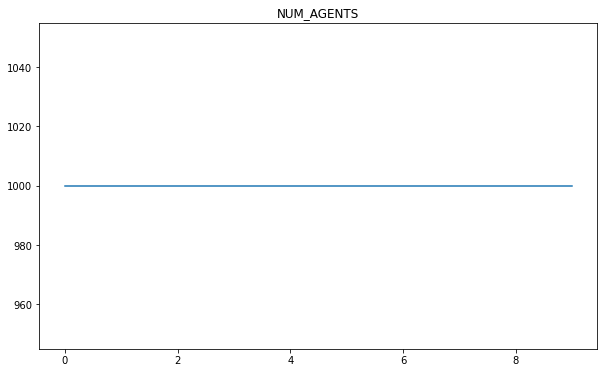

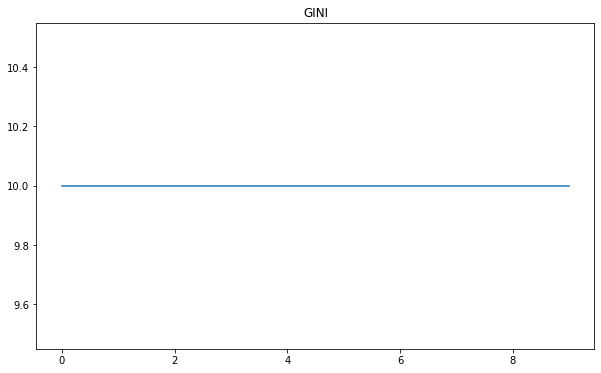

In [22]:
COUNTRY_VARS = ['ENERGY_MIX', 'GDP', 'GDP_GROWTH', 'RandD', 'TECH_PROG', 'EE', 'RPSE', 'INABILITY', 'DWELLINGS', 'ARREARS', 'NUM_AGENTS', 'GINI']


for i in COUNTRY_VARS:

    plt.figure(figsize=(10, 6))
    plt.plot(model_data[i])
    plt.title(str(i))
    plt.show()


In [165]:
# # Get unique steps
# steps = agent_data.index.get_level_values('Step').unique()

# # Create a subplot for each step
# fig, axs = plt.subplots(len(steps), 1, figsize=(10, 5*len(steps)))

# # Create a histogram for each step
# for i, step in enumerate(steps):
#     axs[i].hist(agent_data.xs(step, level="Step")['DISP_INC'], bins=20)
#     axs[i].set_title(f'Disposable Income Distribution - Step {step}')
#     axs[i].set_xlabel('Disposable Income')
#     axs[i].set_ylabel('Number of Citizens')

# plt.tight_layout()
# plt.show()


C:\Users\novak\AppData\Local\Temp\ipykernel_17320\224240864.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return (2 * np.sum((n - i + 1) * x[i-1] for i in range(1, n + 1))) / (n * np.sum(x)) - (n + 1) / n


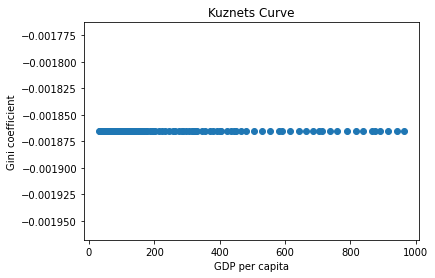

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def gini(x):
    # (Warning: This is a concise calculation method, but it is not efficient!)
    n = len(x)
    return (2 * np.sum((n - i + 1) * x[i-1] for i in range(1, n + 1))) / (n * np.sum(x)) - (n + 1) / n

# Calculate Gini coefficient for each step
gini_coeffs = agent_data['DISP_INC'].groupby('Step').apply(lambda x: gini(x.tolist()))

# Plot Kuznets curve
plt.scatter(model.datacollector.get_model_vars_dataframe()['GDPpc'], gini_coeffs)
plt.xlabel('GDP per capita')
plt.ylabel('Gini coefficient')
plt.title('Kuznets Curve')
plt.show()

initialize_disp_income() is a function that assigns a disposable income category to each citizen when they are created, according to the GINI index. This is a simplified model, not necessarily reflecting real income distributions but giving an approximation.

initialize_flag(percentage) is a helper function that returns True with a probability equal to the given percentage, otherwise False. This is used to set the RPSE, ARREARS, DWELLINGS, and INABILITY flags when a citizen is created.

In the step() method, the citizen's health decreases randomly by 0 to 5 points if RPSE, INABILITY, or DWELLINGS is True, and increases by the same amount if all flags are False. Health is constrained between 0 and 100.